# Лабораторная работа 3

## Часть 1: изюм

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay, calibration_curve

**1. Предобработка**

Датасет с изюмом содержит характеристики двух видов изюма (измеренные по их изображениям, в пикселях; можно сказать, вы занимаетесь классификацией изображений!). Порисуйте графики, чтобы составить представление о распределении признаков *внутри класса*. Мы собираемся использовать наивный байесовский классификатор, LDA и QDА. Примените к признакам преобразования, изменяющие распределение там, где посчитаете нужным. Можно ли сразу по вашим графикам сказать, что предположения, нужные для какого-то из классификаторов, здесь совсем не выполняются?

- *чтобы убрать длинный хвост у распределения справа, можно взять корень или логарифм - это мы знаем. Если же длинный хвост у распределения слева, его можно отразить, прежде чем брать логарифмы.*

Строим графики исходных данных...


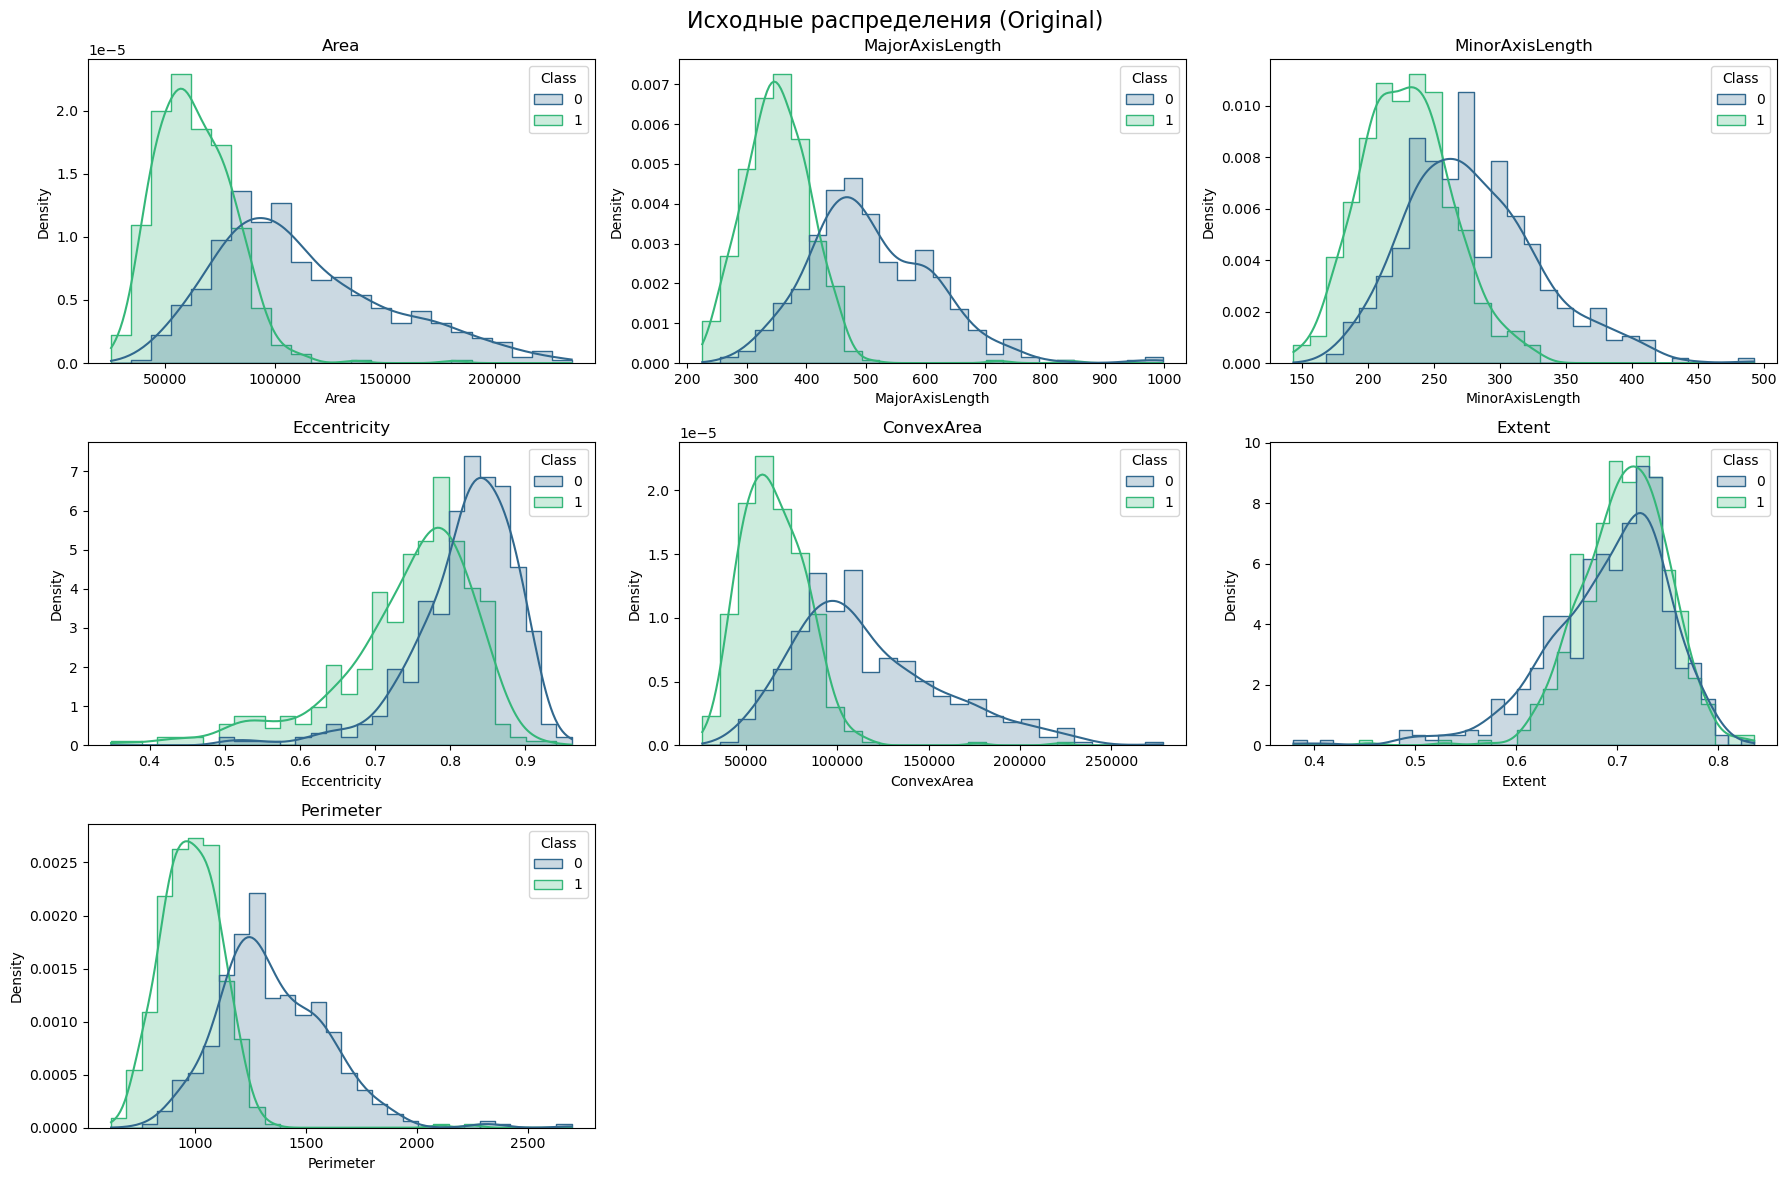

Строим графики трансформированных данных (Все значения положительные)...


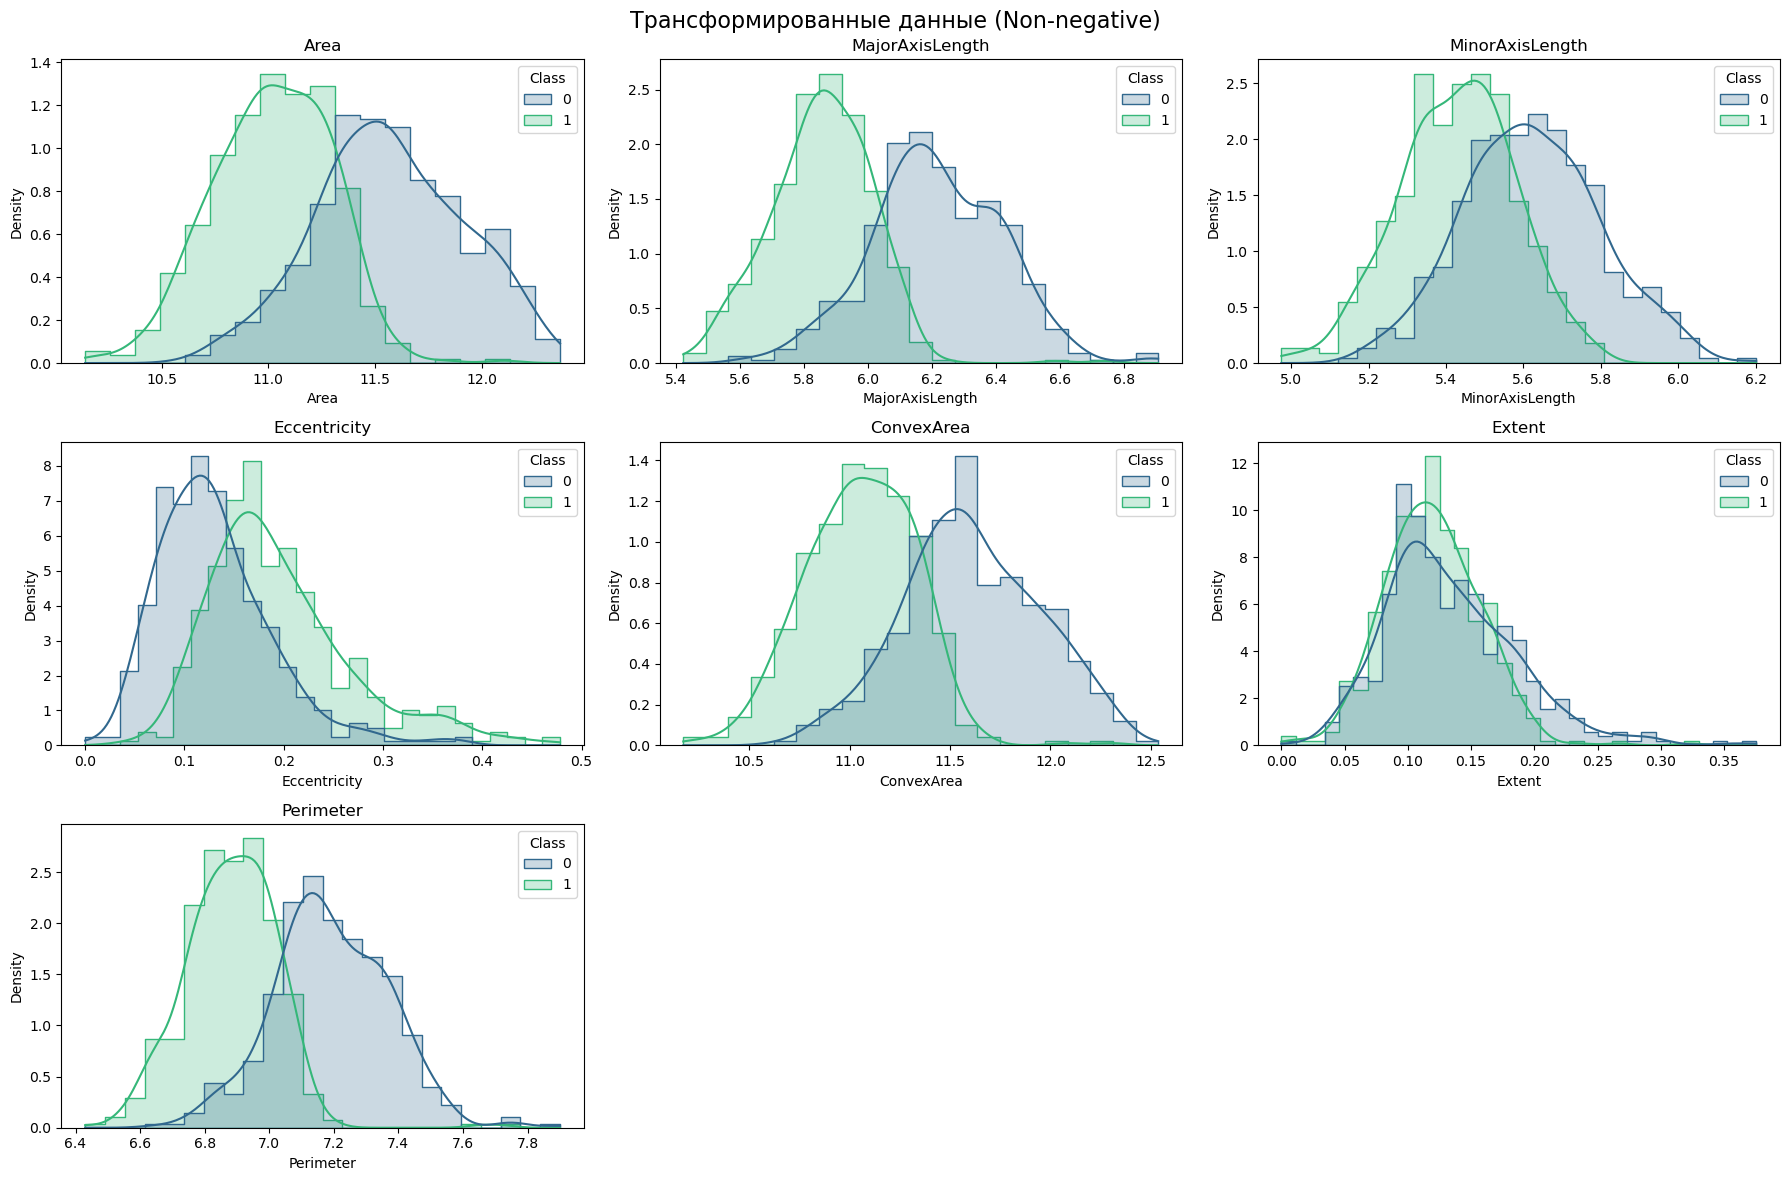

In [18]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("Raisin_Dataset.csv")

le = LabelEncoder()
df["Class"] = le.fit_transform(df["Class"])

X = df.drop("Class", axis=1)
y = df["Class"]
features = X.columns


def plot_distributions(data, target, title):
    n_features = len(data.columns)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))
    axes = axes.flatten()

    for i, col in enumerate(data.columns):
        sns.histplot(
            data=pd.concat([data, target], axis=1),
            x=col,
            hue="Class",
            kde=True,
            ax=axes[i],
            palette="viridis",
            element="step",
            stat="density",
            common_norm=False,
        )
        axes[i].set_title(col)

    for j in range(i + 1, len(axes)):  # type: ignore
        fig.delaxes(axes[j])

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


print("Строим графики исходных данных...")
plot_distributions(X, y, "Исходные распределения (Original)")

X_trans = X.copy()

right_skew_cols = ['Area', 'MajorAxisLength', 'MinorAxisLength', 'ConvexArea', 'Perimeter']
for col in right_skew_cols:
    X_trans[col] = np.log1p(X[col])

left_skew_cols = ['Eccentricity', 'Extent']
for col in left_skew_cols:
    max_val = X[col].max()
    X_trans[col] = np.log((max_val - X[col]) + 1)

print("Строим графики трансформированных данных (Все значения положительные)...")
plot_distributions(X_trans, y, "Трансформированные данные (Non-negative)")

**2. Модели без калибровки**

Отделив 20% данных в тестовое множество, обучите NB, LDA и QDA. Вычислите accuracy, precision, recall, f1-score на тестовом множестве (можно сделать это с помощью `classification_report`, который печатает сразу много метрик)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.2, random_state=42)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print("-" * 60)

models = {
    "Gaussian Naive Bayes": GaussianNB(),
    "LDA (Linear Discriminant Analysis)": LinearDiscriminantAnalysis(),
    "QDA (Quadratic Discriminant Analysis)": QuadraticDiscriminantAnalysis(),
}

for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(f"\n>>> {name}")
    print(classification_report(y_test, y_pred, target_names=["Besni", "Kecimen"], digits=4))
    print("-" * 60)

Размер обучающей выборки: (720, 7)
Размер тестовой выборки: (180, 7)
------------------------------------------------------------

>>> Gaussian Naive Bayes
              precision    recall  f1-score   support

       Besni     0.8706    0.8605    0.8655        86
     Kecimen     0.8737    0.8830    0.8783        94

    accuracy                         0.8722       180
   macro avg     0.8721    0.8717    0.8719       180
weighted avg     0.8722    0.8722    0.8722       180

------------------------------------------------------------

>>> LDA (Linear Discriminant Analysis)
              precision    recall  f1-score   support

       Besni     0.8352    0.8837    0.8588        86
     Kecimen     0.8876    0.8404    0.8634        94

    accuracy                         0.8611       180
   macro avg     0.8614    0.8621    0.8611       180
weighted avg     0.8626    0.8611    0.8612       180

------------------------------------------------------------


LinAlgError: The covariance matrix of class 0 is not full rank. Increase the value of `reg_param` to reduce the collinearity.

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.2, random_state=42)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print("-" * 60)

models = {
    "Gaussian Naive Bayes": GaussianNB(),
    "LDA (Linear Discriminant Analysis)": LinearDiscriminantAnalysis(),
    "QDA (Quadratic Discriminant Analysis)": QuadraticDiscriminantAnalysis(reg_param=0.01),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n>>> {name}")
    print(classification_report(y_test, y_pred, target_names=["Besni", "Kecimen"], digits=4))
    print("-" * 60)

Размер обучающей выборки: (720, 7)
Размер тестовой выборки: (180, 7)
------------------------------------------------------------

>>> Gaussian Naive Bayes
              precision    recall  f1-score   support

       Besni     0.8706    0.8605    0.8655        86
     Kecimen     0.8737    0.8830    0.8783        94

    accuracy                         0.8722       180
   macro avg     0.8721    0.8717    0.8719       180
weighted avg     0.8722    0.8722    0.8722       180

------------------------------------------------------------

>>> LDA (Linear Discriminant Analysis)
              precision    recall  f1-score   support

       Besni     0.8352    0.8837    0.8588        86
     Kecimen     0.8876    0.8404    0.8634        94

    accuracy                         0.8611       180
   macro avg     0.8614    0.8621    0.8611       180
weighted avg     0.8626    0.8611    0.8612       180

------------------------------------------------------------

>>> QDA (Quadratic Discrimi

Используя встроенные в эти классификаторы методы, вычислите также предсказываемые ими вероятности одного из классов, который мы обзовем положительным. Постройте кривые калибровки. Сделать это можно с помощью функции ниже, которую я украла из склерновского туториала и немного переделала, либо написав свою, более эстетичную версию. Будьте готовы прокомментировать увиденное и объяснить, что это за точки и как определяется, где их рисовать

In [21]:
def draw_3_calibrations(clf_list, y_test, n_bins):
    """
    clf_list - список из трех tuples вида (модель, 'имя', вектор предсказанных на тесте вероятностей)
    y_test - реальные метки теста
    n_bins - сколько точек в кривой
    """
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(3, 3)
    colors = plt.get_cmap("Dark2")

    ax_calibration_curve = fig.add_subplot(gs[:2, :3])
    calibration_displays = {}
    for i, (clf, name, y_prob) in enumerate(clf_list):
        disp = CalibrationDisplay.from_predictions(
            y_test, y_prob, name=name, n_bins=n_bins, ax=ax_calibration_curve, color=colors(i)
        )
        calibration_displays[name] = disp

    ax_calibration_curve.grid()
    ax_calibration_curve.set_title("Calibration plots")

    grid_positions = [(2, 0), (2, 1), (2, 2)]
    for i, (_, name, _) in enumerate(clf_list):
        row, col = grid_positions[i]
        ax = fig.add_subplot(gs[row, col])

        ax.hist(
            calibration_displays[name].y_prob,
            range=(0, 1),
            bins=10,
            label=name,
            color=colors(i),
        )
        ax.set(title=name, xlabel="Predicted probability", ylabel="Count")

    plt.tight_layout()
    plt.show()

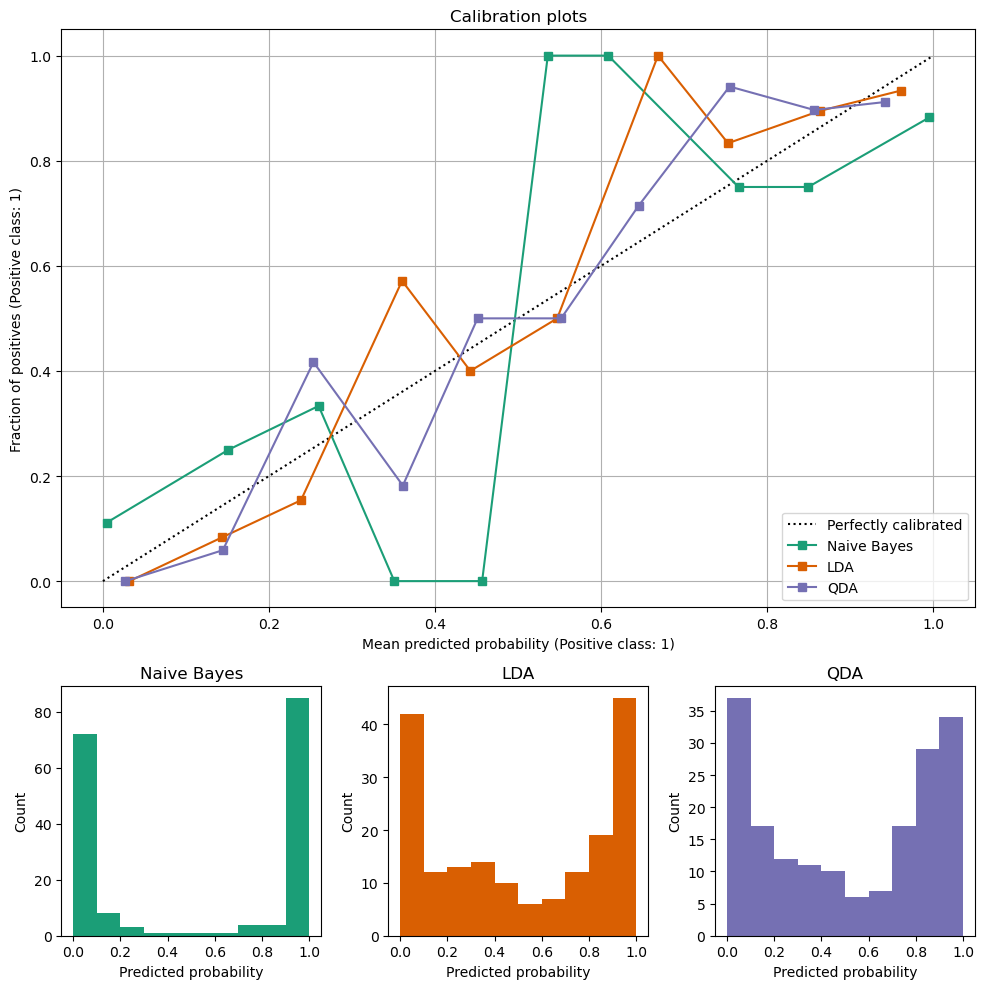

In [22]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
prob_gnb = gnb.predict_proba(X_test)[:, 1]  

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
prob_lda = lda.predict_proba(X_test)[:, 1]

qda = QuadraticDiscriminantAnalysis(reg_param=0.01)
qda.fit(X_train, y_train)
prob_qda = qda.predict_proba(X_test)[:, 1]

clf_list = [(gnb, "Naive Bayes", prob_gnb), (lda, "LDA", prob_lda), (qda, "QDA", prob_qda)]


draw_3_calibrations(clf_list, y_test, n_bins=10)

**3. Перекалибровка**

Для склерновских моделей перекалибровку вероятностей можно осуществить с помощью встроенного `CalibratedClassifierCV`. Сходите в справку и почитайте, что означает это CV и какие у него последствия. Для каждого базового классификатора обучите откалиброванный с методами `sigmoid` и `isotonic`, установив `ensemble=False`. Снова пересчитайте метрики и отрисуйте кривые калибровки (чтобы не громоздить их 9 штук на один рисунок, можете сделать 3 отдельных, по одному для каждой базовой модели)


============================== Naive Bayes ==============================

--- Naive Bayes: Uncalibrated ---
              precision    recall  f1-score   support

       Besni     0.8706    0.8605    0.8655        86
     Kecimen     0.8737    0.8830    0.8783        94

    accuracy                         0.8722       180
   macro avg     0.8721    0.8717    0.8719       180
weighted avg     0.8722    0.8722    0.8722       180


--- Naive Bayes: Sigmoid Calibration ---
              precision    recall  f1-score   support

       Besni     0.8605    0.8605    0.8605        86
     Kecimen     0.8723    0.8723    0.8723        94

    accuracy                         0.8667       180
   macro avg     0.8664    0.8664    0.8664       180
weighted avg     0.8667    0.8667    0.8667       180


--- Naive Bayes: Isotonic Calibration ---
              precision    recall  f1-score   support

       Besni     0.8706    0.8605    0.8655        86
     Kecimen     0.8737    0.8830    0.878

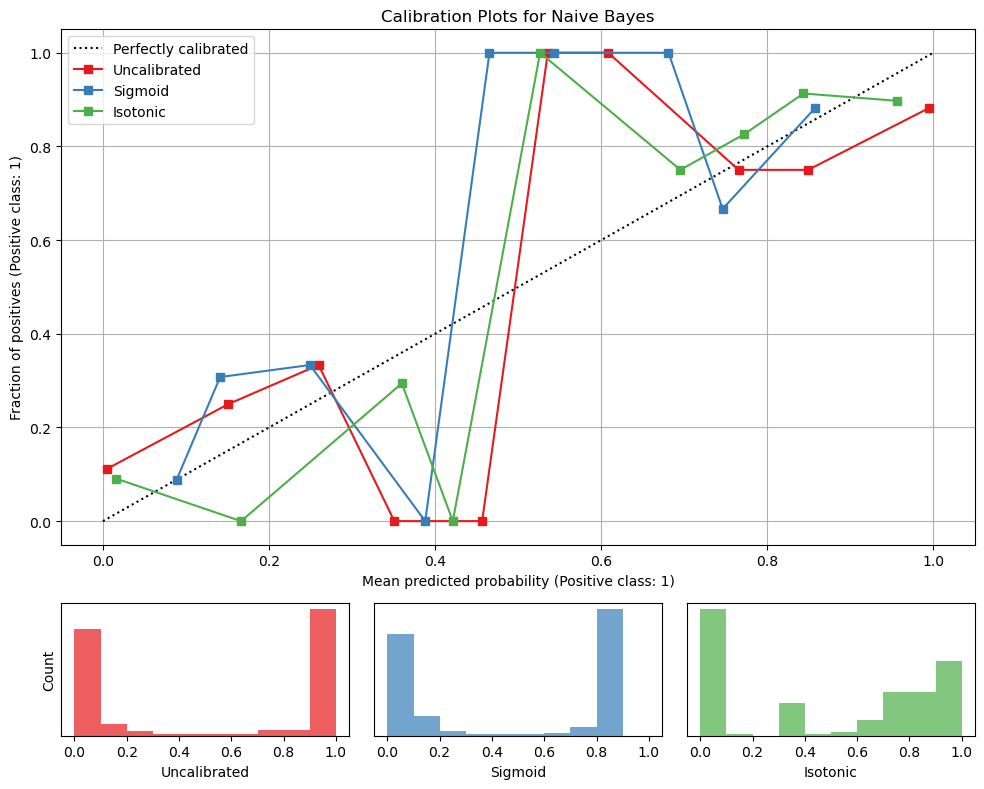


============================== LDA ==============================

--- LDA: Uncalibrated ---
              precision    recall  f1-score   support

       Besni     0.8352    0.8837    0.8588        86
     Kecimen     0.8876    0.8404    0.8634        94

    accuracy                         0.8611       180
   macro avg     0.8614    0.8621    0.8611       180
weighted avg     0.8626    0.8611    0.8612       180


--- LDA: Sigmoid Calibration ---
              precision    recall  f1-score   support

       Besni     0.8191    0.8953    0.8556        86
     Kecimen     0.8953    0.8191    0.8556        94

    accuracy                         0.8556       180
   macro avg     0.8572    0.8572    0.8556       180
weighted avg     0.8589    0.8556    0.8556       180


--- LDA: Isotonic Calibration ---
              precision    recall  f1-score   support

       Besni     0.8409    0.8605    0.8506        86
     Kecimen     0.8696    0.8511    0.8602        94

    accuracy       

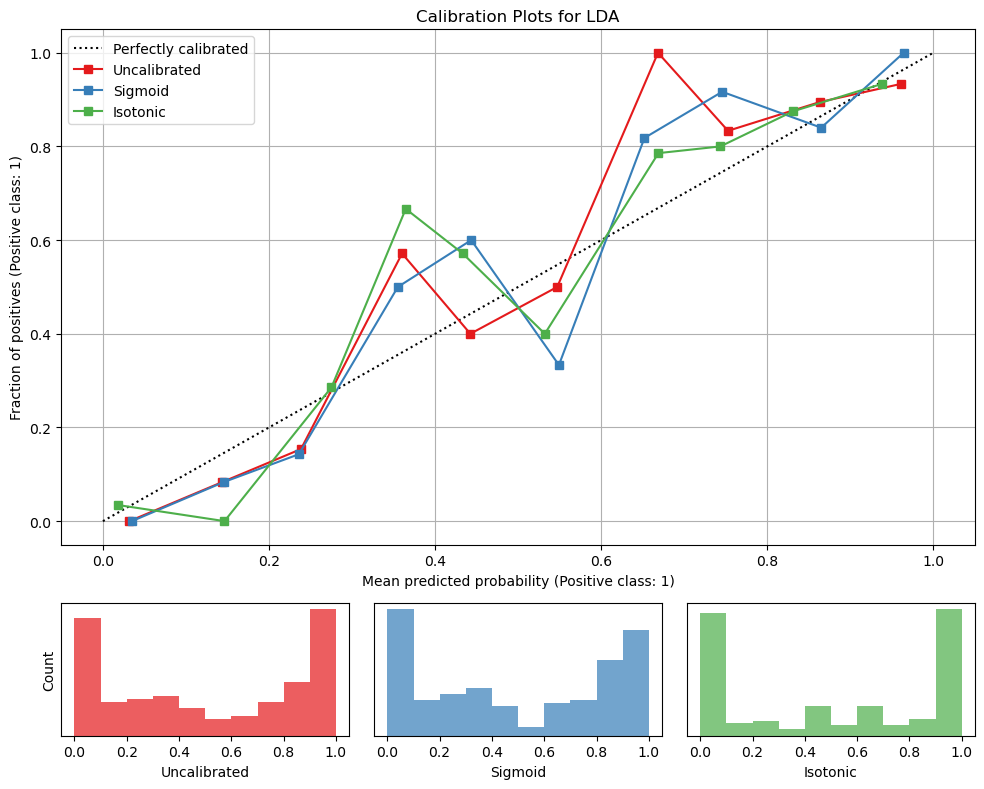


============================== QDA ==============================

--- QDA: Uncalibrated ---
              precision    recall  f1-score   support

       Besni     0.8506    0.8605    0.8555        86
     Kecimen     0.8710    0.8617    0.8663        94

    accuracy                         0.8611       180
   macro avg     0.8608    0.8611    0.8609       180
weighted avg     0.8612    0.8611    0.8611       180


--- QDA: Sigmoid Calibration ---
              precision    recall  f1-score   support

       Besni     0.8523    0.8721    0.8621        86
     Kecimen     0.8804    0.8617    0.8710        94

    accuracy                         0.8667       180
   macro avg     0.8664    0.8669    0.8665       180
weighted avg     0.8670    0.8667    0.8667       180


--- QDA: Isotonic Calibration ---
              precision    recall  f1-score   support

       Besni     0.8523    0.8721    0.8621        86
     Kecimen     0.8804    0.8617    0.8710        94

    accuracy       

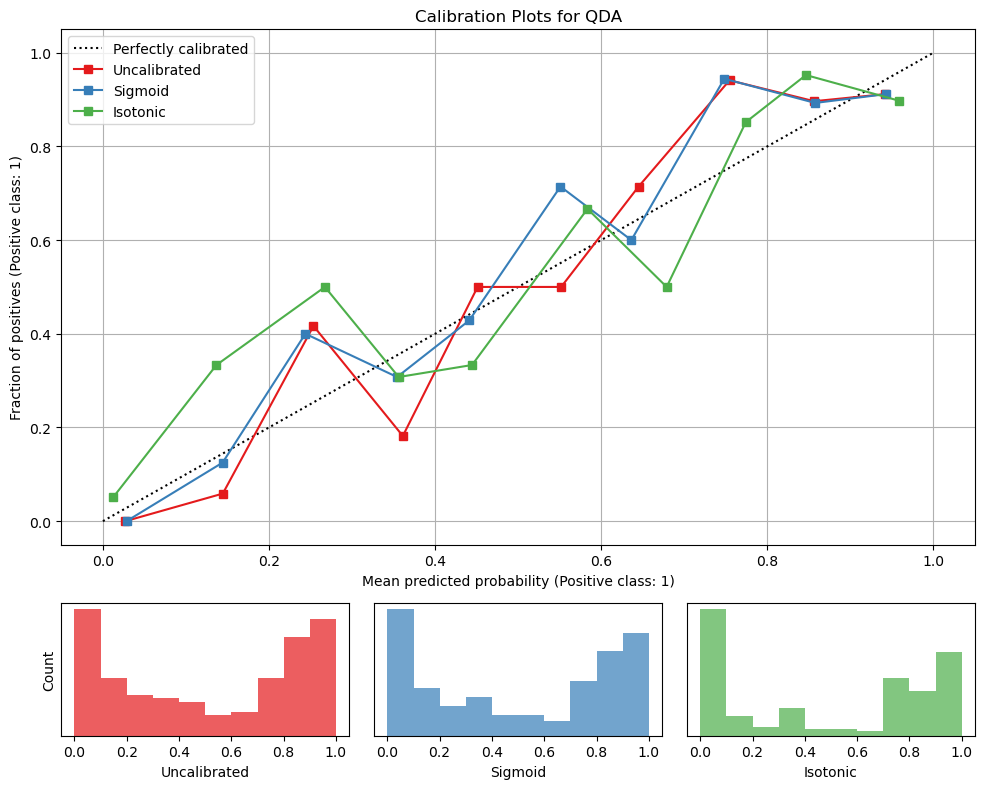

In [23]:
base_models = [
    (GaussianNB(), "Naive Bayes"),
    (LinearDiscriminantAnalysis(), "LDA"),
    (QuadraticDiscriminantAnalysis(reg_param=0.01), "QDA"),
]

for base_clf, name in base_models:
    print(f"\n{'=' * 30} {name} {'=' * 30}")

    plot_list = []

    base_clf.fit(X_train, y_train)
    y_pred_base = base_clf.predict(X_test)
    prob_base = base_clf.predict_proba(X_test)[:, 1]

    print(f"\n--- {name}: Uncalibrated ---")
    print(classification_report(y_test, y_pred_base, target_names=["Besni", "Kecimen"], digits=4))
    plot_list.append((base_clf, "Uncalibrated", prob_base))

    cal_sigmoid = CalibratedClassifierCV(base_clf, method="sigmoid", cv=3)
    cal_sigmoid.fit(X_train, y_train)
    y_pred_sig = cal_sigmoid.predict(X_test)
    prob_sig = cal_sigmoid.predict_proba(X_test)[:, 1]

    print(f"\n--- {name}: Sigmoid Calibration ---")
    print(classification_report(y_test, y_pred_sig, target_names=["Besni", "Kecimen"], digits=4))
    plot_list.append((cal_sigmoid, "Sigmoid", prob_sig))

    cal_iso = CalibratedClassifierCV(base_clf, method="isotonic", cv=3)
    cal_iso.fit(X_train, y_train)
    y_pred_iso = cal_iso.predict(X_test)
    prob_iso = cal_iso.predict_proba(X_test)[:, 1]

    print(f"\n--- {name}: Isotonic Calibration ---")
    print(classification_report(y_test, y_pred_iso, target_names=["Besni", "Kecimen"], digits=4))
    plot_list.append((cal_iso, "Isotonic", prob_iso))

    fig = plt.figure(figsize=(10, 8))
    gs = GridSpec(4, 3)
    colors = plt.get_cmap("Set1")  

    ax_curve = fig.add_subplot(gs[:3, :])
    ax_curve.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    displays = {}
    for i, (clf, label, probs) in enumerate(plot_list):
        disp = CalibrationDisplay.from_predictions(
            y_test, probs, n_bins=10, name=label, ax=ax_curve, color=colors(i)
        )
        displays[label] = disp

    ax_curve.set_title(f"Calibration Plots for {name}")
    ax_curve.grid(True)
    ax_curve.legend()

    for i, (_, label, _) in enumerate(plot_list):
        ax_hist = fig.add_subplot(gs[3, i])
        ax_hist.hist(displays[label].y_prob, range=(0, 1), bins=10, color=colors(i), alpha=0.7)
        ax_hist.set_xlabel(label)
        ax_hist.set_yticks([]) 
        if i == 0:
            ax_hist.set_ylabel("Count")

    plt.tight_layout()
    plt.show()

Какой метод лучше откалибровал вероятности, если верить картинкам? Как калибровка повлияла на метрики - какому классификатору она была полезна, какому - не очень?

## Часть 2: дисбаланс классов

"На самом деле таска угадывания оттока\мошеннических операций по картам\кто не отдаст долг - это максимально типичная задача которая решается в жизни на каждом шагу половиной компаний у себя - поэтому нам надо это тоже посмотреть чтобы хотя бы примерно прикоснуться к тому с чем есть шанс работать в будущем" - сказал по этому поводу ваш прошлый преподаватель

**1. Предобработка** 

Загрузите данные (источник https://www.kaggle.com/datasets/blastchar/telco-customer-churn). Проверьте на наличие пропусков, определите, какие признаки категориальные, а какие - числовые. Предсказывать мы собираемся Churn

In [24]:
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV

In [25]:
# если вы увидели расширение xls и попробовали прочитать это как эксель, возможно, у вас не получилось
data=pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.xls')
data.iloc[0]

customerID                7590-VHVEG
gender                        Female
SeniorCitizen                      0
Partner                          Yes
Dependents                        No
tenure                             1
PhoneService                      No
MultipleLines       No phone service
InternetService                  DSL
OnlineSecurity                    No
OnlineBackup                     Yes
DeviceProtection                  No
TechSupport                       No
StreamingTV                       No
StreamingMovies                   No
Contract              Month-to-month
PaperlessBilling                 Yes
PaymentMethod       Electronic check
MonthlyCharges                 29.85
TotalCharges                   29.85
Churn                             No
Name: 0, dtype: object

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Табличка выше могла ввести нас в заблуждение. Обратите особое внимание на колонку TotalCharges. Осознав, что с ней не так, пересмотрите свои выводы по пропускам и категориальности остальных колонок.

In [27]:

data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")


print("Количество пропусков после преобразования TotalCharges:")
print(data.isnull().sum()[data.isnull().sum() > 0])

data["TotalCharges"] = data["TotalCharges"].fillna(0)

data = data.drop("customerID", axis=1)

data["Churn"] = data["Churn"].map({"Yes": 1, "No": 0})

num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]


cat_cols = [col for col in data.columns if col not in num_cols and col != "Churn"]

print("\n--- Итог предобработки ---")
print(f"Числовые признаки ({len(num_cols)}): {num_cols}")
print(f"Категориальные признаки ({len(cat_cols)}): {cat_cols}")

data.info()

Количество пропусков после преобразования TotalCharges:
TotalCharges    11
dtype: int64

--- Итог предобработки ---
Числовые признаки (3): ['tenure', 'MonthlyCharges', 'TotalCharges']
Категориальные признаки (16): ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 

Посмотрите на дисбаланс классов, на расположение пропусков, на другие потенциально связанные с этими пропусками колонки и решите, что вы хотите с ними делать

Распределение классов (Churn):
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


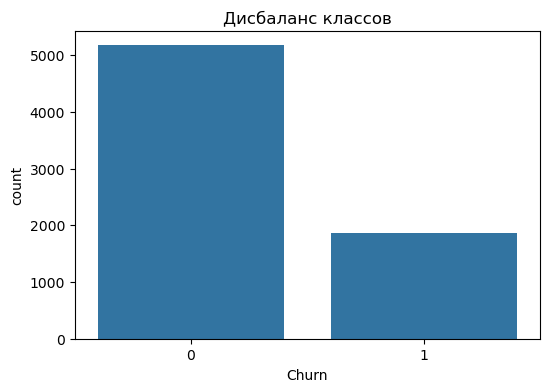

In [28]:
churn_counts = data["Churn"].value_counts()
churn_percentage = data["Churn"].value_counts(normalize=True)

print("Распределение классов (Churn):")
print(churn_percentage)

plt.figure(figsize=(6, 4))
sns.countplot(x="Churn", data=data)
plt.title("Дисбаланс классов")
plt.show()

Сделав все, что хотели, поделите данные на трейн и тест и проверьте, что соотношения классов в них примерно одинаковы

In [29]:
# # если в процессе вы не избавились от датафрейма, можно сделать это за счет normalize
# train, test = train_test_split(data, test_size=0.2, random_state=2)
# train['Churn'].value_counts(normalize=True), test['Churn'].value_counts(normalize=True)


train, test = train_test_split(data, test_size=0.2, random_state=66, stratify=data["Churn"])

print("Train distribution:")
print(train["Churn"].value_counts(normalize=True))

print("\nTest distribution:")
print(test["Churn"].value_counts(normalize=True))

Train distribution:
Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64

Test distribution:
Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64


**2. Логистическая регрессия** 

Предобработайте признаки, чтобы их можно было подавать в регрессию. Будет ли колонка `TotalCharges` избыточной или наоборот, потенциально полезной? Обратите внимание, что при one-hot кодировании вы почти наверняка создаете лишнюю колонку. Если вы не ожидаете, что в тестовых данных появится какая-то неизвестная прежде категория, то значение в одной one-hot колонке линейно выражается через значения в остальных. В `get_dummies` или `OneHotEncoder`'e есть аргумент, позволяющий лишнюю колонку убрать!

Загрузите `LogisticRegression` из sklearn и обучите ее без учета неравенства классов. Вычислите метрики на тестовом и тренировочном наборах: accuracy, precision, recall, f1, roc-auc. Вычислите те же метрики, просто предсказав везде, что "оттока нет", и сделайте вывод о том, какие из них имеют ценность в данной задаче.

Постройте roc- и pr- кривые и объясните, что они такое, почему они так выглядят

- *для построения кривых у sklearn есть готовые функции, правда сами кривые они не рисуют, а только возвращают списки координат, которые надо будет подать в plot, и списки соответствующих границ. Что может быть даже полезно, потому что если бы они отдавали вам только картинки, то вы не могли бы потом понять, какой границе соответствует та замечательная точка графика, где достигается такой хороший баланс между precision и recall*

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

X_train = train.drop("Churn", axis=1)
y_train = train["Churn"]
X_test = test.drop("Churn", axis=1)
y_test = test["Churn"]

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred_train = log_reg.predict(X_train)
y_pred_test = log_reg.predict(X_test)
y_prob_train = log_reg.predict_proba(X_train)[:, 1]
y_prob_test = log_reg.predict_proba(X_test)[:, 1]


def show_metrics(y_true, y_pred, y_prob, label):
    print(f"\n--- {label} Metrics ---")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1-score:  {f1_score(y_true, y_pred):.4f}")
    print(f"ROC-AUC:   {roc_auc_score(y_true, y_prob):.4f}")


show_metrics(y_train, y_pred_train, y_prob_train, "TRAIN")
show_metrics(y_test, y_pred_test, y_prob_test, "TEST")

print("\n" + "=" * 30)
print("BASELINE: Предсказываем везде класс 0 (No Churn)")
y_dummy = np.zeros_like(y_test) 

print(f"Accuracy:  {accuracy_score(y_test, y_dummy):.4f}")
print(f"Precision: {precision_score(y_test, y_dummy, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_dummy):.4f}")
print(f"F1-score:  {f1_score(y_test, y_dummy):.4f}")
print("ROC-AUC:   0.5000 (Константное предсказание)")


--- TRAIN Metrics ---
Accuracy:  0.8060
Precision: 0.6585
Recall:    0.5585
F1-score:  0.6044
ROC-AUC:   0.8517

--- TEST Metrics ---
Accuracy:  0.7899
Precision: 0.6168
Recall:    0.5508
F1-score:  0.5819
ROC-AUC:   0.8315

BASELINE: Предсказываем везде класс 0 (No Churn)
Accuracy:  0.7346
Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000
ROC-AUC:   0.5000 (Константное предсказание)


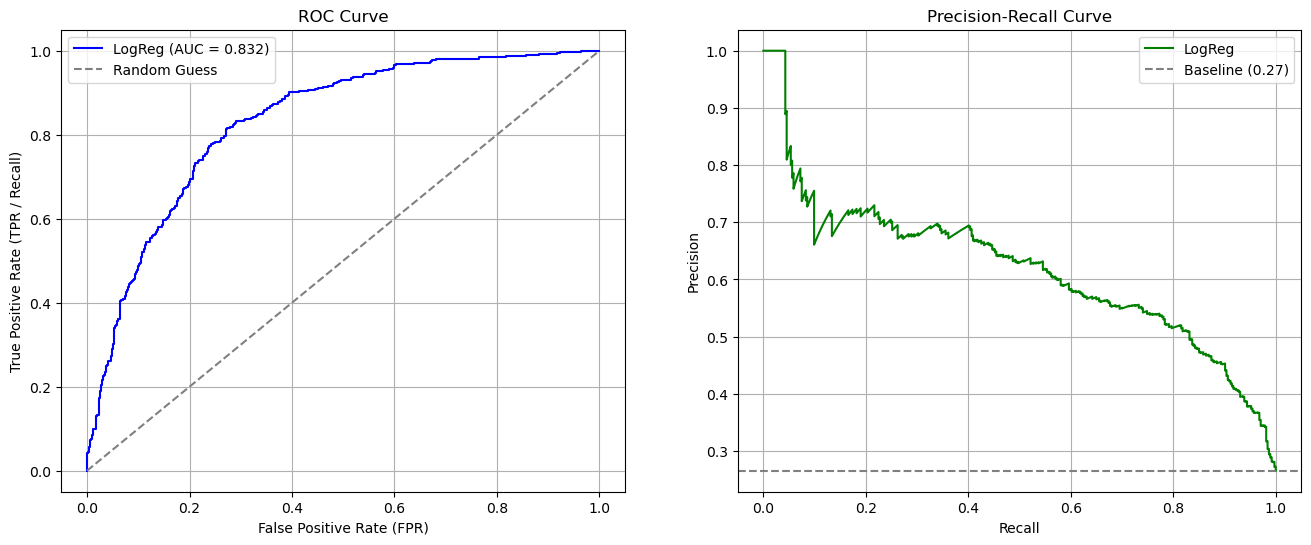

In [31]:
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob_test)
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob_test)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(fpr, tpr, label=f"LogReg (AUC = {roc_auc_score(y_test, y_prob_test):.3f})", color="blue")
ax[0].plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
ax[0].set_xlabel("False Positive Rate (FPR)")
ax[0].set_ylabel("True Positive Rate (TPR / Recall)")
ax[0].set_title("ROC Curve")
ax[0].legend()
ax[0].grid()

ax[1].plot(recall, precision, label="LogReg", color="green")
baseline_pr = y_test.mean()
ax[1].axhline(y=baseline_pr, color="gray", linestyle="--", label=f"Baseline ({baseline_pr:.2f})")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].set_title("Precision-Recall Curve")
ax[1].legend()
ax[1].grid()

plt.show()

**3. Дисбаланс классов** 

Когда мы выводили формулы для логистической регрессии, мы использовали предоположение о равенстве классов ($P(y=0)=P(y=1)$). Допустим, на самом деле соотношение между классами $\frac{P(y=0)}{P(y=1)}=\alpha$, но мы это проигнорировали и вычислили $P(y=1|X)$ и log odds (это $z=\log \frac{P(y=1|X)}{P(y=0|X)}$, и оно говорит нам о том, где проходит разделяющая плоскость) по старой формуле. 

1) Выведите, в каком соотношении находятся эти значения вероятностей с "честными". Предложите, что изменить в обучении или инференсе, чтобы учесть дисбаланс классов и снова считать правильные вероятности. Запишите!

$$z_{true​}=z_{model​}−\log(\alpha)$$


2) Спуститесь в глубину архивов исходного кода sklearn для логистической регрессии (попасть туда можно, нажав \[source\] на страничке справки). Там найдите древние свитки, на которых записано, как дисбаланс классов обрабатывается в `LogisticRegression`. Перепишите эти знания предков в ноутбук и попробуйте объяснить, почему было сделано именно так.

3) Выбравшись из архивов, переобучите регрессию уже с учетом дисбаланса классов и пересчитайте все те же метрики. Посмотрите на precision-recall кривую, оцените, следует ли вам сдвинуть threshold с 0.5 куда-то еще. На основании чего вы можете сделать такой вывод?

**Дальше будет задание где нам нужны все наши модели одновременно, так что не удаляйте их из памяти пока!**

- *Для перебора параметров вообще можно использовать `GridSearchCV` или `RandomizedSearchCV`. Однако он требует выбрать некоторую метрику для сравнения*
- *заметьте, что никто не запрещает вам поставить в `class_weight` какие угодно коэффициенты дисбаланса. Как знать, может, нужная вам метрика станет лучше, если вы соврете о степени дисбаланса?*
- *`f1_score` - выбор желающих усидеть на двух стульях. Но что если мы хотим усидеть на одном стуле немного больше, чем на втором: мы как бы подозреваем, что, например, recall, важнее, но все же не хотим упускать из виду precision? Существует `fbeta_score` - взвешенная версия*

In [ ]:
# как-то вот так это может работать, если вы хотите еспользовать ее в переборе параметров
fb = make_scorer(fbeta_score, beta=3)
grid = GridSearchCV(base_classifier, param_grid={...}, scoring=fb, cv=3)

**4. Обыкновенная регрессия**

Попробуйте решить задачу с помощью `RidgeClassifier` и сравните метрики с логистической регрессией. Может, не так плоха линейная регрессия на друх классах?

Нам в этой лабе понадобятся вероятности, а у `RidgeClassifier` их нет, разве что какие-то confidence scores. Чтобы не посылать вас обратно копаться в исходном коде, просто скажем, что наши вероятности будут считаться взятием сигмоиды от того, что вернула `decision_function`

**5. Наивный Байес** 

Хотелось бы опробовать наивный байесовский классификатор на этой задаче, раз уж для L/QDA она не очень подходит в силу кучи категорий, но вот беда: наши признаки и категориальные, и числовые. Казалось бы, в чем проблема, но похоже в sklearn до сих пор нет версии байеса, которая бы умела с таким работать. Ваши варианты:

- подумать, как можно собрать математически эквивалентную версию из `GaussianNB` и `CategoricalNB`
- написать свой NB с нуля
- установить вот эту имплементацию https://github.com/remykarem/mixed-naive-bayes/tree/master

Выбирая вариант, учтите, что дальше нам от этого классификатора потребуются не просто ответы, а вероятности, или их подобие. У sklearn классификаторы обычно имеют метод `predict_proba`. В mixed-naive-bayes он какой-то тоже есть.

Прежде чем приступать к обучению классификатора, можно проверить кое-что еще. Наши численные признаки. Если вы не выбрали писать свой собственный классификатор, то заметьте, что готовый ожидает, что численные признаки нормально распределены. Но так ли это? Что вы можете сделать? Стоит ли оно того?

*логистическая регрессия с сигмоидой конечно тоже была заинтересована в нормальном распределении, но нам все равно пришлось бы скормить ей кучу категориальных фичей, так что...*

Обучите байесовский классификатор, посчитайте метрики

- *Для кодирования категориальных признаков для байеса лучше подойдет не one-hot, а `OrdinalEncoder`. Сравните его также с `LabelEncoder`: в чем разница?*

**6. Калибровка вероятностей**

1) Для наших классификаторов (логистическая регрессия, линейная регрессия, байесовский) постройте кривые калибровки вероятностей и прокомментируйте. 

> Как выглядят кривые калибровки для очень неуверенного классификатора? Для очень уверенного, но дающего неправильные ответы?

2. Попробуйте поправить вероятности. Для этого вообще существует `CalibratedClassifierCV`. Ниже приведен пример использования - разберитесь, что это за аргументы.

> Каждый из трех классификаторов засуньте вместе с тренировочным множеством в калибровщик. Попробуйте как `sigmoid`, так и `isotonic`. Постройте scatter графики старых и новых вероятностей, опишите, что с ними стало после калибровки. Отрисуйе новые кривые калибровки вместе со старыми (опять же, можно сделать три графика, отдельный для каждого классификатора).

In [ ]:
base_lr = LogisticRegression(...)# тут внутрь можно прописать ваши параметры, которые вы хотите зафиксировать
sigmoid_lr = CalibratedClassifierCV(base_lr, cv=4, method='sigmoid', ensemble=False)

Если вы написали своего наивного байеса, я за него не отвечаю, а вот если воспользовались готовым, то сейчас столкнетесь с проблемой: он не совсем совместим с этой калибровочной оболочкой. В частности, оболочка не верит, что это вообще классификатор и это вызывает проблемы в процессе. Возможно, вы придумаете какое-то более элегантное решение. Если вы тоже не особо программист, то, полистав исходный код, могу предложить вам следующий костыль: выдать ему фальшивое удостоверение классификатора и парочку классов для нашего конкретного случая.

In [ ]:
class ConvincingMixedNB(MixedNB):
    def __init__(self, categorical_features=None, max_categories=None,
                 alpha=0.5, priors=None, var_smoothing=1e-9):
        MixedNB.__init__(self, categorical_features, max_categories, alpha, priors, var_smoothing)
        self.classes_ = np.array([0,1])
        self._estimator_type = 'classifier'

Пересчитайте метрики, сравните со старыми. Также перерисуйте precision-recall кривые и сравните со старыми. Увиденное объясните.

**7.** Здесь было задание про овер-андерсэмплинг, но возможно стоит сжалиться над вами и пропустить его. Просто знайте, что нито вам не запрещает попробовать на этом датасете всяческие сэмплинги и посмотреть, что будет!